In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree

import agama
agama.setUnits(mass=1E10, length=1, velocity=1)

time_conv = 977.79222167

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [3]:
sn0_list = []
sn1_list = []
sn1G_list = []
# sn1G_list = []
# sn1Gnw_list = []
# sn1GnwCOM_list = []
idx_list = np.arange(0, 600, 50)
# idx_list = np.arange(0, 60, 10)
# idx_list = [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
fields=['Coordinates', 'Velocities', 'Masses', 'Acceleration']
for idx in tqdm(idx_list):
    sn0 = read_snap(idx, 0, lvl='lvl3', parttype=None, fields=None)
    sn0_list.append(sn0)
    
    try:
        sn1 = read_snap(idx, 1, lvl='lvl3', parttype=None, fields=None)
        sn1_list.append(sn1)
    except:
        pass
    
    try:
        sn1G = read_snap(idx, 1, lvl='lvl3-GFM', parttype=None, fields=None)
        sn1G_list.append(sn1G)
    except:
        pass


A Jupyter Widget

KeyboardInterrupt: 

In [4]:
from numba import njit
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        sum_x_in_bin[j] /= N_in_bin[j]
        sum_y_in_bin[j] /= N_in_bin[j]
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

In [5]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier, debug=False):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
        if debug:
            print(tlist[i], fourier[key]['Rlist'][np.argmax(A2/A0)], np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [6]:
fourierN_l4 = read_fourier(0, lvl='lvl4')
fourierN_l3 = read_fourier(0, lvl='lvl3')

fourierS_l3 = read_fourier(1, lvl='lvl3')
fourierG_l3 = read_fourier(1, lvl='lvl3-GFM')
fourierN_l4['snapshot_300'].keys()

<KeysViewHDF5 ['A0', 'A10i', 'A10r', 'A1i', 'A1r', 'A2i', 'A2r', 'A3i', 'A3r', 'A4i', 'A4r', 'A5i', 'A5r', 'A6i', 'A6r', 'A7i', 'A7r', 'A8i', 'A8r', 'A9i', 'A9r', 'Rlist']>

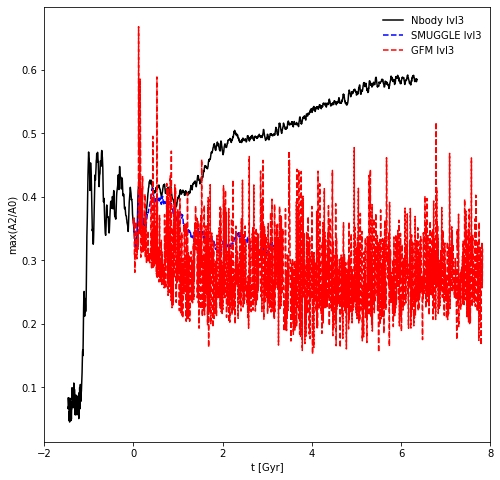

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dt = 0.01

# t, A2A0 = extract_t_max_A2A0(fourier3)
# ax.plot(t/1000.0, A2A0, label='Sg 10')

start_snap = 300
t, A2A0 = extract_t_max_A2A0(fourierN_l3)
t -= t[start_snap]
ax.plot(t/1000.0, A2A0, label='Nbody lvl3', c='k')

start_snap = 300
t, A2A0 = extract_t_max_A2A0(fourierN_l4, debug=False)
t -= t[start_snap]
t300 = t[start_snap]
# ax.plot(t/1000.0, A2A0, label='Nbody lvl4', c='k', ls='dashed')
# ax.scatter(t/1000.0, A2A0, label='Nbody lvl4', c='k')
# print(A2A0)

# start_snap = 300
t, A2A0 = extract_t_max_A2A0(fourierS_l3, debug=False)
# t -= t[300]
# t300 = t[300]
ax.plot(t/1000.0, A2A0, label='SMUGGLE lvl3', c='b', ls='dashed')
# ax.scatter(t/1000.0, A2A0, label='Nbody lvl4', c='k')
# print(A2A0)

# start_snap = 300
t, A2A0 = extract_t_max_A2A0(fourierG_l3, debug=False)
# t -= t[300]
# t300 = t[300]
ax.plot(t/1000.0, A2A0, label='GFM lvl3', c='r', ls='dashed')
# ax.scatter(t/1000.0, A2A0, label='Nbody lvl4', c='k')
# print(A2A0)

# t, SFR = binned_average(sfr_8[:,0], sfr_8[:,2], dt)
# ax.plot(t, SFR, label='8')

ax.legend(frameon=False)
ax.set(xlabel='t [Gyr]', ylabel='max(A2/A0)', xlim=(0, 1))
ax.set_xlim(-2, 8)
plt.show()

In [8]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def main_bar_angle(dat, Rbin = 5, firstkey = 150, nmax = 10):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [9]:
outN_l3 = main_bar_angle(fourierN_l3)
outS_l3 = main_bar_angle(fourierS_l3, firstkey=0)
outG_l3 = main_bar_angle(fourierG_l3, firstkey=0)
# outN_l4 = main_bar_angle(fourierN_l4)
# out1 = main_bar_angle(fourier1, firstkey=0)


/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in multiply


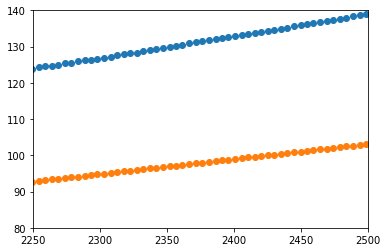

In [28]:
plt.scatter(outG_l3['time'], outG_l3['bar_angle'])
plt.scatter(outS_l3['time'], outS_l3['bar_angle'])
plt.xlim(2250, 2500)
plt.ylim(80, 140)
plt.show()

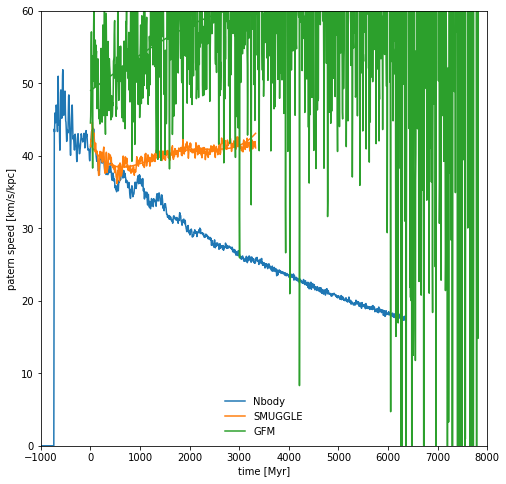

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n=5

dat = outN_l3
name = 'Nbody'

time = dat['time']
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
# ax.plot(time-time[400], ps, label=name, c='k')
ax.plot(time-time[300], true_ps, label=name)
# dt = time[300] - time[400]

# dat = out3
# name = 'Sg 10'

# time = dat['time']
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# # ax.plot(time-time[0], ps, label=name)
# ax.plot(time-time[0], true_ps, label=name)

dat = outS_l3
name = 'SMUGGLE'

time = dat['time']
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
l=ax.plot(time-time[0], ps, label=name)
ax.plot(time-time[0], true_ps, c=l[0].get_color())


dat = outG_l3
name = 'GFM'

time = dat['time']
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
l=ax.plot(time-time[0], ps, label=name)
ax.plot(time-time[0], true_ps, c=l[0].get_color())

# dat = out6
# name = 'snap400'

# time = dat['time'] + dt
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# l=ax.plot(time, ps, label=name)
# ax.plot(time, true_ps, label=name, c=l[0].get_color())


ax.legend(frameon=False)

ax.set(xlim=(-1000, 8000))
# ax.set(xlim=(2500,3000))
ax.set(ylim=(0, 60), xlabel='time [Myr]', ylabel='patern speed [km/s/kpc]')
plt.show()

## Rbar and corotation

In [24]:
def compute_pot(sn, center=np.array([0., 0., 0.])):
#     center = sn.BoxSize/2.0
#     center = np.array([center, center, center])

    bar_position = np.array([]).reshape((0, 3))
    dark_position = np.array([]).reshape((0, 3))

    bar_mass = np.array([])
    dark_mass = np.array([])

    for i in [0, 2, 3, 4]:
        if sn.NumPart_Total[i] > 0.0:
            pos_i = getattr(sn, 'part'+str(i)).pos.value - center
    
            if sn.MassTable[i] == 0.0:
                mass_i = getattr(sn, 'part'+str(i)).mass.value
            else:
                mass_i = np.full(sn.NumPart_Total[i], sn.MassTable[i])
    
            bar_position = np.concatenate((bar_position, pos_i))
            bar_mass = np.concatenate((bar_mass, mass_i))
    
    dark_position = sn.part1.pos.value - center
    dark_mass = np.full(sn.NumPart_Total[1], sn.MassTable[1])

    pdark = agama.Potential(type="Multipole",
                            particles=(dark_position, dark_mass),
                            symmetry='a', gridsizeR=20, lmax=2)

    pbar = agama.Potential(type="CylSpline",
                            particles=(bar_position, bar_mass),
                            symmetry='a', gridsizer=20, gridsizez=20,
                            mmax=0, Rmin=0.2,
                            Rmax=50, Zmin=0.02, Zmax=10)

    pot = agama.Potential(pdark, pbar)
    
    return pot


In [14]:
def compute_vc_kappa(pot):
    R = np.linspace(0,20,1000)
    points = np.column_stack((R, R*0, R*0))
    frc, drv = pot.forceDeriv(points)
    kappa = np.sqrt(-drv[:,0] - 3*frc[:,0]/R)
    vc = np.sqrt(-R*pot.force(points)[:,0])
    
    return R, vc, kappa

In [15]:
pot0_list = []
pot1_list = []
for i,idx in enumerate(tqdm(idx_list)):
    sn0 = sn0_list[i]
    pot0 = compute_pot(sn0)
    pot0_list.append(pot0)
    
    sn1 = sn1_list[i]
    pot1 = compute_pot(sn1)
    pot1_list.append(pot1)

A Jupyter Widget

RuntimeError: Error in creating potential: Keyboard interrupt

In [ ]:
pot0 = compute_pot(sn0_list[0], center=np.array([0., 0., 0.]))
pot1 = compute_pot(sn1_list[-1], center=np.array([200., 200., 200.]))

In [21]:
R0, vc0, kappa0 = compute_vc_kappa(pot0)
R1, vc1, kappa1 = compute_vc_kappa(pot1)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [ ]:
# plt.plot(R0, vc0, label='Nbody')
plt.plot(R1, vc1, label='SMUGGLE')
plt.legend()
plt.show()

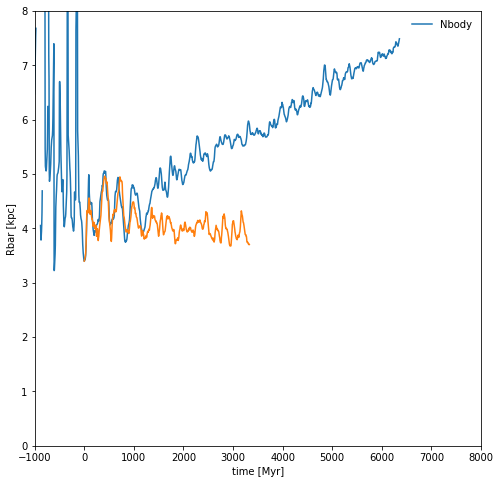

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n=5

dat = outN_l3
name = 'Nbody'

time = dat['time']
Rbar = dat['Rbar']
# ax.plot(time-time[400], ps, label=name, c='k')
ax.plot(time-time[300], Rbar, label=name)
# dt = time[300] - time[400]

# dat = out3
# name = 'Sg 10'

# time = dat['time']
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# # ax.plot(time-time[0], ps, label=name)
# ax.plot(time-time[0], true_ps, label=name)

dat = outS_l3
name = 'SMUGGLE'

time = dat['time']
Rbar = dat['Rbar']
ax.plot(time-time[0], Rbar)

# dat = out6
# name = 'snap400'

# time = dat['time'] + dt
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# l=ax.plot(time, ps, label=name)
# ax.plot(time, true_ps, label=name, c=l[0].get_color())


ax.legend(frameon=False)

ax.set(xlim=(-1000, 8000))
# ax.set(xlim=(2500,3000))
ax.set(ylim=(0, 8), xlabel='time [Myr]', ylabel='Rbar [kpc]')
plt.show()

#### 